In [1]:
# Data processing
# Visualization of vertical profiles
import string
import warnings
from datetime import datetime
from pathlib import Path

import cartopy.crs as ccrs
import iris
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Visualization of flight tracks and regions
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from iris.pandas import as_data_frame
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Point, Polygon
from sklearn.metrics import mean_squared_error

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
crs_main = ccrs.PlateCarree(central_longitude=180)
crs_aux = ccrs.PlateCarree()

In [2]:
from util_commons import EXPERIMENTS, GASES

In [3]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="xarray")
warnings.filterwarnings("ignore")
plt.rcParams["mathtext.default"] = "regular"

#### Global definitions and constants

In [27]:
SOURCES = [
    "atom",
    "xojnh",
    "xojni",
    "xojnw",
    "xojnl",
]  # used in thesis: xojnc indead of xojnw  "xojnh",
REGIONS = [
    (1, "n_pacific"),
    (2, "c_pacific"),
    (3, "s_pacific"),
    (4, "s_e_atlantic"),
    (5, "c_atlantic"),
    (6, "n_atlantic"),
    (7, "greenland"),
    (8, "w_canada"),
]
SEASONS = ["1702", "1608"]  # add ['1607', '1701']
SPECIES = {
    "ch4": {
        "def": ["CH4_NOAA"],
        "group": "NOAA-Picarro",
        "latex": "$CH_4$",
        "ppn": "ppbv",
        "min": 1750,
        "max": 2070,
    },
    "c2h6": {
        "def": ["Ethane_WAS", "Ethene_WAS", "Ethyne_WAS"],
        "latex": "$C_2H_6$",
        "ppn": "pptvC",
        "min": 0,
        "max": 8000,
    },
    "c3h8": {
        "def": ["Propane_WAS"],
        "latex": "$C_3H_8$",
        "ppn": "pptv",
        "min": 0,
        "max": 1500,
    },  # without propene
    "no": {
        "def": ["NO_CL"],
        "group": "NOyO3-NO",
        "latex": "NO",
        "ppn": "ppbv",
        "min": 0,
        "max": 0.1,
    },  # 0.5
    "nox": {
        "def": ["NO_CL", "NO2_CL"],
        "group": ["NOyO3-NO", "NOyO3-NO2"],
        "latex": "$NO_x$",
        "ppn": "ppbv",
        "min": 0,
        "max": 0.5,
    },  # 3.5
    "noy": {
        "def": ["NOy_CL"],
        "group": ["NOyO3-NOy"],
        "latex": "$NO_y$",
        "ppn": "ppbv",
        "min": 0,
        "max": 3.5,
    },  # 3.5
    "o3": {
        "def": ["O3_CL"],
        "group": "NOyO3-O3",
        "latex": "$O_3$",
        "ppn": "ppbv",
        "min": 0,
        "max": 100,
    },  # 600
    "oh": {
        "def": ["OH_pptv"],
        "group": "ATHOS-HOx",
        "latex": "OH",
        "ppn": "pptv",
        "min": 0,
        "max": 3.5,
    },
    "meono2": {
        "def": ["MeONO2_WAS"],
        "latex": "$MeONO_2$",
        "ppn": "pptv",
        "min": 0,
        "max": 70,
    },
    "etono2": {
        "def": ["EtONO2_WAS"],
        "latex": "$EtONO_2$",
        "ppn": "pptv",
        "min": 0,
        "max": 10,
    },
    "nprono2": {
        "def": ["n-PrONO2_WAS"],
        "latex": "$nPrONO_2$",
        "ppn": "pptv",
        "min": 0,
        "max": 5,
    },
    "iprono2": {
        "def": ["i-PrONO2_WAS"],
        "latex": "$iPrONO_2$",
        "ppn": "pptv",
        "min": 0,
        "max": 25,
    },
}

#### Read vertical profiles data

In [6]:
path_to_prcd = Path.home() / "uea" / "phd" / "models" / "ukca" / "processed" / "vertical_profiles"

vrbls = {}
for src in SOURCES:
    vrbls[src] = {}
    for ir, reg in REGIONS:
        vrbls[src][reg] = {}
        for season in SEASONS:
            vrbls[src][reg][season] = {}
            for sp in SPECIES.keys():
                vrbls[src][reg][season][sp] = {}
                for vr in ["mean", "std_dev", "count"]:
                    try:
                        vrbls[src][reg][season][sp][vr] = iris.load_cube(
                            str(path_to_prcd / f"vp_{season}_{src}_r{ir}_{sp}_{vr}.nc")
                        )
                    except OSError:
                        pass

In [9]:
# Choose one species
the_species = "noy"

#### Prepare geospatical coordinates data

In [10]:
# Read data
path_to_atom = Path.home() / "uea" / "phd" / "obs" / "ATom" / "nc" / "data"

group = SPECIES[the_species].get("group", "WAS")

lons, lats = {}, {}
for season in SEASONS:
    inp_files = sorted(path_to_atom.glob(f"MER-WAS_DC8_20{season}*.nc"))
    # Deal with lon, lat separately
    ds = xr.open_mfdataset(
        inp_files, group="MMS", decode_cf=True, combine="nested", concat_dim="time"
    )
    lons[season] = ds.G_LONG.values
    lats[season] = ds.G_LAT.values

    if isinstance(group, str):
        ds = xr.open_mfdataset(
            inp_files, group=group, decode_cf=True, combine="nested", concat_dim="time"
        )
    else:
        ds = []
        for _group in group:
            ds.append(
                xr.open_mfdataset(
                    inp_files, group=_group, decode_cf=True, combine="nested", concat_dim="time"
                )
            )
        ds = xr.merge(ds)

    _dependencies = ds[SPECIES[the_species]["def"]]
    _lon_lat = np.any([np.isnan(ds[i].values) for i in _dependencies], axis=0)
    # Mask out coordinates of missing data
    lons[season][_lon_lat] = np.nan
    lats[season][_lon_lat] = np.nan

try:
    # seems to be out of place
    lons["1608"][541], lats["1608"][541] = np.nan, np.nan
except KeyError:
    # No August 2016 in the dictionary, skipping this step
    pass

#### Define geographical regions

In [11]:
# Construct pairs of coordinate points
flt_points = {}
for season in SEASONS:
    flt_points[season] = [Point(i, j) for i, j in zip(lons[season], lats[season])]
# Geographical regions
r1_llon_ukca, r1_ulon_ukca = 195.9375, 214.6875
r1_llon, r1_ulon = r1_llon_ukca - 360, r1_ulon_ukca - 360
r1_llat, r1_ulat = 21.875, 53.125
r1 = Polygon([(r1_llon, r1_llat), (r1_llon, r1_ulat), (r1_ulon, r1_ulat), (r1_ulon, r1_llat)])
r2_llon_ukca, r2_ulon_ukca = 169.6875, 201.5625
r2_1_llon, r2_1_ulon = r2_llon_ukca, 180
r2_2_llon, r2_2_ulon = -180, r2_ulon_ukca - 360
r2_llat, r2_ulat = -40.625, 20.625
r2_1 = Polygon(
    [(r2_1_llon, r2_llat), (r2_1_llon, r2_ulat), (r2_1_ulon, r2_ulat), (r2_1_ulon, r2_llat)]
)
r2_2 = Polygon(
    [(r2_2_llon, r2_llat), (r2_2_llon, r2_ulat), (r2_2_ulon, r2_ulat), (r2_2_ulon, r2_llat)]
)
r3_llon_ukca, r3_ulon_ukca = 180.9375, 285.9375
r3_llon, r3_ulon = r3_llon_ukca - 360, r3_ulon_ukca - 360
r3_llat, r3_ulat = -70.625, -50.625
r3 = Polygon([(r3_llon, r3_llat), (r3_llon, r3_ulat), (r3_ulon, r3_ulat), (r3_ulon, r3_llat)])
r4_llon_ukca, r4_ulon_ukca = 312.1875, 334.6875
r4_llon, r4_ulon = r4_llon_ukca - 360, r4_ulon_ukca - 360
r4_llat, r4_ulat = -45.625, -25.625
r4 = Polygon([(r4_llon, r4_llat), (r4_llon, r4_ulat), (r4_ulon, r4_ulat), (r4_ulon, r4_llat)])
r5_llon_ukca, r5_ulon_ukca = 323.4375, 344.0625
r5_llon, r5_ulon = r5_llon_ukca - 360, r5_ulon_ukca - 360
r5_llat, r5_ulat = -6.875, 36.875
r5 = Polygon([(r5_llon, r5_llat), (r5_llon, r5_ulat), (r5_ulon, r5_ulat), (r5_ulon, r5_llat)])
r6_llon_ukca, r6_ulon_ukca = 321.5625, 338.4375
r6_llon, r6_ulon = r6_llon_ukca - 360, r6_ulon_ukca - 360
r6_llat, r6_ulat = 38.125, 63.125
r6 = Polygon([(r6_llon, r6_llat), (r6_llon, r6_ulat), (r6_ulon, r6_ulat), (r6_ulon, r6_llat)])
r7_llon_ukca, r7_ulon_ukca = 269.0625, 321.5625
r7_llon, r7_ulon = r7_llon_ukca - 360, r7_ulon_ukca - 360
r7_llat, r7_ulat = 59.375, 81.875
r7 = Polygon([(r7_llon, r7_llat), (r7_llon, r7_ulat), (r7_ulon, r7_ulat), (r7_ulon, r7_llat)])
# r8_llon_ukca, r8_ulon_ukca = 237.1875, 269.0625
# r8_llon, r8_ulon = r8_llon_ukca-360, r8_ulon_ukca-360
# r8_llat, r8_ulat = 31.875, 50.625
# r8 = Polygon([(r8_llon, r8_llat), (r8_llon, r8_ulat), (r8_ulon, r8_ulat), (r8_ulon, r8_llat)])
r9_llon_ukca, r9_ulon_ukca = (
    201.5625,
    233.4375,
)  # between 234 and 237.1875 there is a spike in alkanes!
r9_llon, r9_ulon = r9_llon_ukca - 360, r9_ulon_ukca - 360
r9_llat, r9_ulat = 61.875, 81.875
r9 = Polygon([(r9_llon, r9_llat), (r9_llon, r9_ulat), (r9_ulon, r9_ulat), (r9_ulon, r9_llat)])

In [12]:
all_regions = {
    "n_pacific": {
        "title": "North Pacific",
        "polygon": r1,
        "plt_bounds": [r1_llon_ukca, r1_ulon_ukca, r1_llat, r1_ulat],
    },
    "c_pacific": {
        "title": "Central Pacific",
        "polygon": (r2_1, r2_2),
        "plt_bounds": [r2_llon_ukca, r2_ulon_ukca, r2_llat, r2_ulat],
    },
    "s_pacific": {
        "title": "South Pacific",
        "polygon": r3,
        "plt_bounds": [r3_llon_ukca, r3_ulon_ukca, r3_llat, r3_ulat],
    },
    "s_e_atlantic": {
        "title": "South-East Atlantic",
        "polygon": r4,
        "plt_bounds": [r4_llon_ukca, r4_ulon_ukca, r4_llat, r4_ulat],
    },
    "c_atlantic": {
        "title": "Central Atlantic",
        "polygon": r5,
        "plt_bounds": [r5_llon_ukca, r5_ulon_ukca, r5_llat, r5_ulat],
    },
    "n_atlantic": {
        "title": "North Atlantic",
        "polygon": r6,
        "plt_bounds": [r6_llon_ukca, r6_ulon_ukca, r6_llat, r6_ulat],
    },
    "greenland": {
        "title": "Greenland",
        "polygon": r7,
        "plt_bounds": [r7_llon_ukca, r7_ulon_ukca, r7_llat, r7_ulat],
    },
    "w_canada": {
        "title": "Alaska",  # 'West Canada'
        "polygon": r9,
        "plt_bounds": [r9_llon_ukca, r9_ulon_ukca, r9_llat, r9_ulat],
    },
}

In [13]:
def find_points_within(list_of_points, poly_region):
    """Find points within `list_of_points` that are within a polygon."""
    if isinstance(poly_region, (list, tuple, set)):
        # if a region comprises multiple parts
        within_region = []
        for i, p_r in enumerate(poly_region):
            within_each_poly = []
            for j, p in enumerate(list_of_points):
                within_each_poly.append(p.within(p_r))
            within_region.append(within_each_poly)
        within_region = np.any(within_region, axis=0)
    elif isinstance(poly_region, Polygon):
        within_region = []
        for p in list_of_points:
            within_region.append(p.within(poly_region))
    else:
        raise ValueError("`poly_region` should be a shapely Polygon or a list of Polygons.")
    return np.asarray(within_region)

#### Plot vertical profiles for one selected species

In [14]:
def make_plots_with_map(figsize=(20, 15)):
    """
    Make a super plot.

    Parameters
    ----------
    figsize: tuple
        Figure size in inches.

    Returns
    -------
    fig: matplotlib.figure.Figure
        Parent figure.
    ax_dict: dict
        Dictionary of "vert_prof" axes for vertical profiles;
        and the "map" entry for a cartopy axes in the middle.
    """
    ncol = 10
    nrow = 4

    ax_dict = {}
    ax_dict["vert_prof"] = {}

    fig = plt.figure(figsize=figsize, facecolor="w")

    gs = gridspec.GridSpec(nrow, ncol, figure=fig, wspace=0.5, hspace=0.3)

    ax_dict["vert_prof"]["w_canada"] = plt.subplot(gs[0, 1:3]), plt.subplot(gs[0, 3:5])
    ax_dict["vert_prof"]["greenland"] = plt.subplot(gs[0, 5:7]), plt.subplot(gs[0, 7:9])

    ax_dict["vert_prof"]["n_pacific"] = plt.subplot(gs[1, :2]), plt.subplot(gs[1, 2:4])
    ax_dict["vert_prof"]["n_atlantic"] = plt.subplot(gs[1, 6:8]), plt.subplot(gs[1, 8:])
    ax_dict["vert_prof"]["c_pacific"] = plt.subplot(gs[2, :2]), plt.subplot(gs[2, 2:4])
    ax_dict["vert_prof"]["c_atlantic"] = plt.subplot(gs[2, 6:8]), plt.subplot(gs[2, 8:])
    ax_dict["vert_prof"]["s_pacific"] = plt.subplot(gs[3, 1:3]), plt.subplot(gs[3, 3:5])
    ax_dict["vert_prof"]["s_e_atlantic"] = (
        plt.subplot(gs[3, 5:7]),
        plt.subplot(gs[3, 7:9]),
    )

    ax_dict["map"] = plt.subplot(gs[1:3, 4:6], projection=crs_main)
    ax_dict["map"].coastlines()
    ax_dict["map"].set_extent([-200, -5, -90, 90], crs=crs_aux)  # -200, -5, -90, 90 if center 180
    ax_dict["map"].set_xticks([-180, -120, -60], crs=crs_aux)
    ax_dict["map"].set_yticks([-60, -30, 0, 30, 60], crs=crs_aux)
    ax_dict["map"].xaxis.set_major_formatter(lon_formatter)
    ax_dict["map"].yaxis.set_major_formatter(lat_formatter)

    return fig, ax_dict

In [15]:
# Plotting parameters
path_to_figs = Path.home() / "uea" / "phd" / "results" / "xojn" / "atom_xojn_vps" / "with_count"
KWARGS = {
    "atom": dict(linestyle="-", linewidth=2, markersize=5, elinewidth=2, capsize=3, label="ATom"),
    "xojnh": dict(
        color="C6", linestyle="-", linewidth=2, markersize=5, elinewidth=2, capsize=3, label="CHEM"
    ),
    "xojni": dict(
        color="C0", linestyle="-", linewidth=2, markersize=5, elinewidth=2, capsize=3, label="MARI"
    ),
    "xojnw": dict(
        color="C3", linestyle="-", linewidth=2, markersize=5, elinewidth=2, capsize=3, label="FIRE"
    ),  # in thesis: xojnc
    "xojnl": dict(
        color="C2", linestyle="-", linewidth=2, markersize=5, elinewidth=2, capsize=3, label="FULL"
    ),
}  # ,
#           'xojng': dict(color='C7', fmt='-o', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='BASE')}

kw_atom_map_season = {
    "1608": {"color": "grey", "ms": 5, "marker": "o"},
    "1702": {"color": "k", "ms": 5, "marker": "o"},
}

kwargs_patch = dict(facecolor="r", alpha=0.2, edgecolor="k", transform=ccrs.PlateCarree())

plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.linewidth"] = 1


def obs_count_formatter(x):
    if x > 0:
        s = f"{int(x):d}"
    else:
        s = ""
    return s

In [16]:
def mmr_to_vmr_in_ppn(arr_mmr, molar_mass, ppn):
    M_air = 28.97  # molar mass of dry air [g mol-1]
    if ppn == "ppbv":
        power_of_ten = 1e9
    if ppn == "pptv":
        power_of_ten = 1e12
    arr_vmr = arr_mmr * (M_air / molar_mass) * power_of_ten
    return arr_vmr

In [20]:
the_species = "noy"

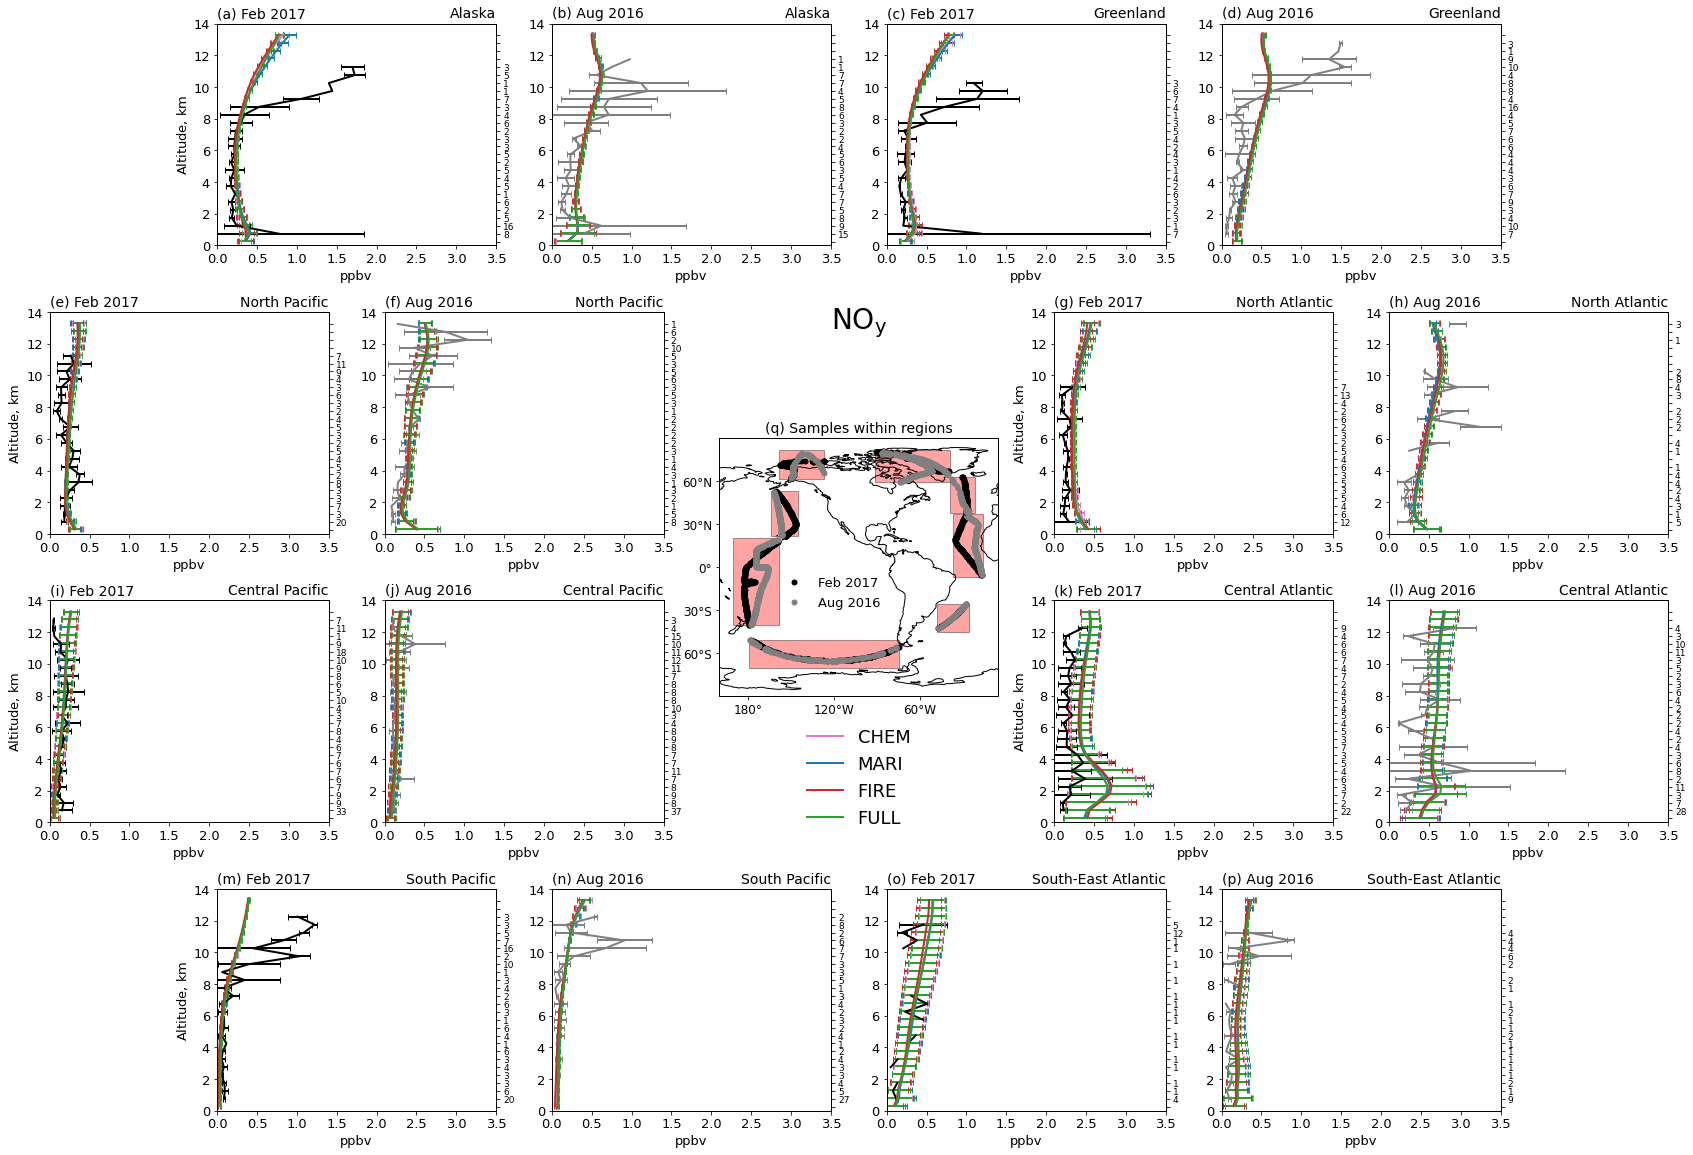

In [29]:
fig, ax_dict = make_plots_with_map(figsize=(29, 20))
YLIM = [0, 14]

# VERTICAL PROFILES
ilabels = iter(string.ascii_lowercase)
for reg, ax_pair in ax_dict["vert_prof"].items():
    for i, (season, ax) in enumerate(zip(SEASONS, ax_pair)):
        for src in SOURCES:
            cubes = vrbls[src][reg][season][the_species]
            y = cubes["mean"].coord("altitude").points * 1e-3

            if src != "atom":
                if the_species in ["nox", "noy"]:
                    x = cubes["mean"].data.squeeze() * 1e9
                    xerr = cubes["std_dev"].data.squeeze() * 1e9
                else:
                    x = mmr_to_vmr_in_ppn(
                        cubes["mean"].data.squeeze(),
                        GASES[the_species]["molar_mass"],
                        SPECIES[the_species]["ppn"],
                    )
                    xerr = mmr_to_vmr_in_ppn(
                        cubes["std_dev"].data.squeeze(),
                        GASES[the_species]["molar_mass"],
                        SPECIES[the_species]["ppn"],
                    )
            else:
                x = cubes["mean"].data.squeeze()
                xerr = cubes["std_dev"].data.squeeze()

            plt_kw = dict(color=kw_atom_map_season[season]["color"])
            plt_kw.update(KWARGS[src])
            ax.errorbar(x, y, xerr=xerr, **plt_kw)

            if src == "atom":
                count = cubes["count"].data.squeeze()
                ax2 = ax.twinx()
                ax2.set_yticks(y)
                ax2.set_yticklabels([obs_count_formatter(i) for i in count], fontsize=9)
                ax2.set_ylim(YLIM)

        season_name = datetime.strptime(season, "%y%m").strftime("%b %Y")
        ilabel = next(ilabels)
        ax.set_title(f"({ilabel}) {season_name}", loc="left")
        ax.set_title(all_regions[reg]["title"], loc="right")

        ax.set_xlim([SPECIES[the_species]["min"], SPECIES[the_species]["max"]])
        ax.set_ylim(YLIM)
        if ilabel in ["a", "e", "g", "i", "k", "m"]:  #  i == 0:
            # Add y-label only to the left plot
            ax.set_ylabel("Altitude, $km$")
        ax.set_xlabel(SPECIES[the_species]["ppn"])

# MAP
ax_dict["map"].tick_params(labelsize=12)
ax_dict["map"].annotate(
    SPECIES[the_species]["latex"],
    xy=(0.5, 1.45),
    xycoords="axes fraction",
    va="center",
    ha="center",
    fontsize=28,
)
ax_dict["map"].set_title(
    f"({next(ilabels)}) Samples within regions",
    loc="center",
)
for region_name, region_dict in all_regions.items():
    for season in SEASONS:
        season_name = datetime.strptime(season, "%y%m").strftime("%b %Y")
        inds = find_points_within(flt_points[season], region_dict["polygon"])
        _lons, _lats = lons[season][inds], lats[season][inds]
        ax_dict["map"].plot(
            _lons,
            _lats,
            linestyle="",
            transform=ccrs.PlateCarree(),
            **kw_atom_map_season[season],
            label=season_name,
        )

        bnds = region_dict["plt_bounds"]
        ax_dict["map"].add_patch(
            mpatches.Rectangle(
                xy=[bnds[0], bnds[2]],
                width=bnds[1] - bnds[0],
                height=bnds[3] - bnds[2],
                **kwargs_patch,
            )
        )

ax_dict["map"].legend(
    labels=["Feb 2017", "Aug 2016"],
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.4, 0.4),
    fontsize=13,
)

dummy_handles = [
    Line2D(
        [0],
        [0],
        **{k: v for k, v in KWARGS[src].items() if k not in ["elinewidth", "capsize"]},
    )
    for src in SOURCES
    if src != "atom"
]
ax_dict["vert_prof"]["s_pacific"][1].legend(
    handles=dummy_handles,
    labels=[KWARGS[src]["label"] for src in SOURCES if src != "atom"],
    frameon=False,
    loc="center",
    bbox_to_anchor=(1.1, 1.5),
    fontsize=18,
)

fig.savefig(path_to_figs / f'atom_xojn_vps_{the_species}_xlim_diff.png', bbox_inches='tight') # _xlim_diff

In [24]:
break

SyntaxError: 'break' outside loop (<ipython-input-24-6aaf1f276005>, line 4)

#### Calculate statistics

In [ ]:
# Dictionaries used to clean up a dataframe
reg_dict = {
    "n_pacific": "North Pacific",
    "c_pacific": "Central Pacific",
    "s_pacific": "South Pacific",
    "s_e_atlantic": "South East Atlantic",
    "c_atlantic": "Central Atlantic",
    "n_atlantic": "North Atlantic",
    "greenland": "Greenland",
    "w_canada": "Alaska",
}
mon_dict = {"1702": "Feb", "1608": "Aug"}
exp_dict = {
    "xojnd": "BASE OLD",
    "xojng": "BASE",
    "xojnh": "CHEM",
    "xojni": "MARI",
    "xojnw": "FIRE",  # in thesis: xojnc
    "xojnl": "FULL",
    "xolnb": "ORIG",
    "xolna": "UPDT",
}
spec_dict = {
    "ch4": "\ce{CH4}",
    "c2h6": "\ce{C2H6}",
    "c3h8": "\ce{C3H8}",
    "no": "NO",
    "nox": "\ce{NO_x}",
    "o3": "\ce{O3}",
    "oh": "OH",
    "meono2": "\ce{MeONO2}",
    "etono2": "\ce{EtONO2}",
    "nprono2": "\ce{nPrONO2}",
    "iprono2": "\ce{iPrONO2}",
}

In [ ]:
the_species = "o3"

In [ ]:
# Calculate a simple linear regression
linreg_keys = ["slope", "intercept", "rvalue", "pvalue", "stderr"]
stats = {}
for ir, reg in REGIONS:
    stats[reg] = {}
    for season in SEASONS:
        stats[reg][season] = {}
        atom_stats = vrbls["atom"][reg][season][the_species]["mean"]
        for src in SOURCES[1::]:
            stats[reg][season][src] = {}
            ukca_stats = iris.util.squeeze(vrbls[src][reg][season][the_species]["mean"])
            # Remove NaNs
            atom_stats_nonan = atom_stats[~np.isnan(atom_stats.data) & ~np.isnan(ukca_stats.data)]
            ukca_stats_nonan = ukca_stats[~np.isnan(atom_stats.data) & ~np.isnan(ukca_stats.data)]
            # Calculate slope, intercept, R-value, p-value, standard error
            linreg_res = scipy.stats.linregress(atom_stats_nonan.data, ukca_stats_nonan.data)
            stats[reg][season][src] = {key: getattr(linreg_res, key) for key in linreg_keys}
            stats[reg][season][src].update(
                {"rmse": np.sqrt(mean_squared_error(atom_stats_nonan.data, ukca_stats_nonan.data))}
            )

# Assemble data into a dataframe
df = pd.concat(
    {
        kk: pd.concat({k: pd.DataFrame.from_dict(v, "index") for k, v in vv.items()}, axis=0)
        for kk, vv in stats.items()
    },
    axis=0,
)

# Calculate R**2
df["rsquared"] = df["rvalue"] ** 2

# Replace big numbers with * sign (not used)
def value_formatter(x):
    if np.isnan(x):
        return "*"
    else:
        return f"{x:.2f}"


# Clean up a dataframe
df.index.names = ["Region", "Month", "Experiment"]
df.columns = ["Slope", "Intercept", "R", "p-value", "Std err", "RMSE", "\ce{R^2}"]
df_renamed = (
    df.rename(index=reg_dict, level="Region")
    .rename(index=mon_dict, level="Month")
    .rename(index=exp_dict, level="Experiment")
)
# df_renamed_masked = df_renamed.mask(abs(df_renamed) > 1, np.nan) # does not change anything for R and R**2
# Choose columns to be shown in .tex and adjust table caption
chosen_columns = ["R", "\ce{R^2}", "RMSE"]
caption = (
    "Correlation coefficient (R), correlation of determination (\ce{R^2}) and root-mean-square error (RMSE) derived from a simple linear regression for "
    + f"{spec_dict[the_species]} vertical profiles."
)

# Rearrange a dataframe: place Feb and Aug columns side by side
new_df_dict = {}
for col_name in df_renamed.columns:
    levels = df_renamed.index.get_level_values("Month").unique()
    _df = pd.concat([df_renamed[col_name].xs(month, level="Month") for month in levels], axis=1)
    _df.columns = levels.values
    new_df_dict[col_name] = _df.apply(lambda x: " | ".join([value_formatter(i) for i in x]), axis=1)
new_df = pd.DataFrame.from_dict(new_df_dict)

# Save table to .tex
path_to_thesis = Path.home() / "UEA" / "PhD" / "thesis" / "chapters" / "ch3"
# new_df.to_latex(path_to_thesis / f'stats_{the_species}.tex',
#                 escape=False,
#                 columns=chosen_columns,
#                 column_format = 'llccccc',
#                 longtable=True,
#                 caption=caption,
#                 label=f'tab:stats_{the_species}')

In [ ]:
# print(new_df.to_latex(escape=False,
#                       columns=chosen_columns,
#                       column_format = 'llccccc',
#                       float_format='%.2f',
#                       na_rep='*',
#                       longtable=True,
#                       caption=caption,
#                       label=f'tab:{the_species}_stats'))

In [ ]:
break

#### Look at individual profiles

In [ ]:
# plt.plot(vrbls[base][place][month][the_species]['mean'].data, vrbls[sens][place][month][the_species]['mean'].coord('altitude').points * 1e-3, marker='o');
# plt.plot(vrbls[sens][place][month][the_species]['mean'].data, vrbls[sens][place][month][the_species]['mean'].coord('altitude').points * 1e-3, marker='o');
# # plt.xlim(1850,2000);
# plt.grid()

In [ ]:
base, sens = "atom", "xojnl"
place = "n_atlantic"
month = "1608"
the_species = "o3"
maxlev = 27  # 17=8, 27 max
plt.plot(
    vrbls[sens][place][month][the_species]["mean"].data[0:maxlev].squeeze()
    - vrbls[base][place][month][the_species]["mean"].data[0:maxlev].squeeze(),
    vrbls[sens][place][month][the_species]["mean"].coord("altitude").points[0:maxlev] * 1e-3,
    marker="o",
)
plt.grid()
plt.ylim(0, 14)
# plt.xlim(-20,20);

In [ ]:
maxlev = 27  # 17=8, 27 max
plt.plot(
    (
        vrbls[sens][place][month][the_species]["mean"].data[0:maxlev].squeeze()
        - vrbls[base][place][month][the_species]["mean"].data[0:maxlev].squeeze()
    )
    * 100
    / vrbls[base][place][month][the_species]["mean"].data[0:maxlev].squeeze(),
    vrbls[sens][place][month][the_species]["mean"].coord("altitude").points[0:maxlev] * 1e-3,
    marker="o",
)
plt.grid()
plt.ylim(0, 14)
# plt.xlim(-50,50);